In [1]:
import plyfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
from os.path import join
import pickle

In [2]:
def makedirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# read data

In [3]:
name_format = '{}.ply'

In [4]:
bunny = dict()
names = ['bun000', 'bun045', 'bun090', 'bun180', 'bun270', 'bun315']
colors = {
    'bun000': 'r',
    'bun045': 'b',
    'bun090': 'k',
    'bun180': 'g',
    'bun270': 'c',
    'bun315': 'y'
}
for name in names:
    bunny[name] = plyfile.PlyData.read('/workdir/data/bunny/data/{}'.format(name_format.format(name)))

/usr/local/lib/python3.5/dist-packages/plyfile.py:914: UserWarning: loadtxt: Empty input file: "[]"
  data = _np.loadtxt(list(_islice(fields, n)), val_t, ndmin=1)


In [5]:
conf_filepath = '/workdir/data/bunny/data/bun.conf'
configs = dict()
filenames = [name_format.format(name) for name in names]
with open(conf_filepath, 'r') as f:
    for line in f.readlines():
        line = line.strip().split(' ')
        if line[0] == 'bmesh':
            if line[1] in filenames:
                name = names[filenames.index(line[1])]
                nums = list(map(float, line[2:]))
                configs[name] = {
                    't': nums[:3],
                    'quat': nums[3:]
                }
configs

{'bun000': {'quat': [0.0, 0.0, 0.0, 1.0], 't': [0.0, 0.0, 0.0]},
 'bun045': {'quat': [0.00548449, -0.294635, -0.0038555, 0.955586],
  't': [-0.0520211, -0.000383981, -0.0109223]},
 'bun090': {'quat': [0.000335889, -0.708202, 0.000602459, 0.706009],
  't': [2.20761e-05, -3.34606e-05, -7.20881e-05]},
 'bun180': {'quat': [-0.00215148, 0.999996, -0.0015001, 0.000892527],
  't': [0.000116991, 2.47732e-05, -4.6283e-05]},
 'bun270': {'quat': [0.000462632, 0.707006, -0.00333301, 0.7072],
  't': [0.000130273, 1.58623e-05, 0.000406764]},
 'bun315': {'quat': [0.00449209, 0.38422, -0.00976512, 0.923179],
  't': [-0.00646017, -1.36122e-05, -0.0129064]}}

# visualize and project points

In [6]:
def quat2rotmtx(quat, old=True):
    # qw, qx, qy, qz = quat
    qx, qy, qz, qw = quat
    
    return np.array([
        [1 - 2*qy*qy - 2*qz*qz, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx*qx - 2*qz*qz, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx*qx - 2*qy*qy]
    ], dtype=np.float32).T

def get_coords(name):
    return np.array([
        bunny[name]['vertex']['x'],
        bunny[name]['vertex']['y'],
        bunny[name]['vertex']['z']    
    ], dtype=np.float32)
    
def get_projected_coords(name):
    coords = get_coords(name)
    t = np.array(configs[name]['t'], dtype=np.float32)[:, np.newaxis]
    rotmtx = quat2rotmtx(configs[name]['quat'])
    coords = rotmtx.dot(coords) + t
    return coords

In [7]:
def plot_x_y(key):
    plt.figure(figsize=(20, 5))
    coords = get_projected_coords(key)
    
    ax = plt.subplot(1, 3, 1)
    ax.scatter(coords[0, :], coords[1, :], s=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    ax = plt.subplot(1, 3, 2)
    ax.scatter(coords[0, :], coords[2, :], s=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    
    ax = plt.subplot(1, 3, 3)
    ax.scatter(coords[2, :], coords[1, :], s=0.1)
    ax.set_xlabel('z')
    ax.set_ylabel('y')
    
    plt.show()

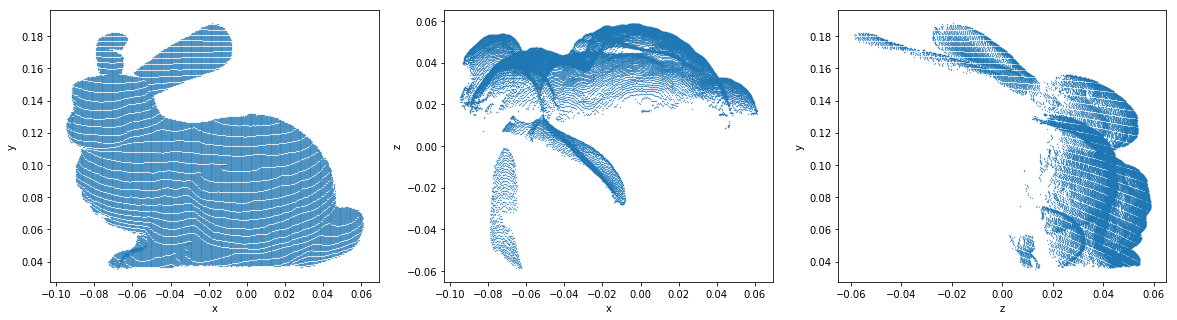

In [8]:
plot_x_y('bun000')

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


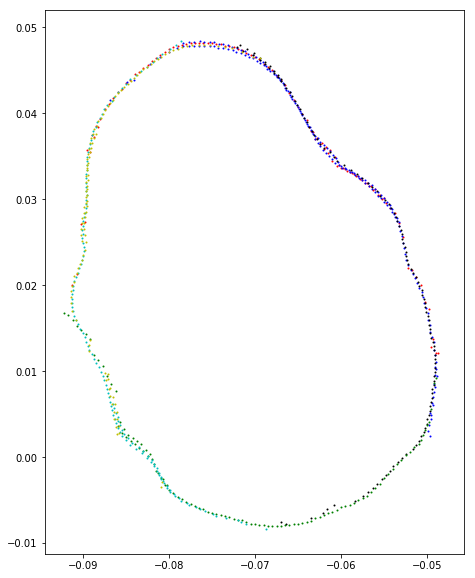

In [9]:
d = 0.0005
mid = 0.14
plt.figure(figsize=(10, 10))
for name in names:
    coords = get_projected_coords(name)
    mask = (coords[1, :] > mid - d) & (coords[1, :] < mid + d)
    plt.scatter(coords[0, :][mask], coords[2, :][mask], s=1, c=colors[name])
# plt.scatter([0], [0], s=100)
plt.axes().set_aspect('equal')
# plt.xlim((-0.15, 0.15))
# plt.ylim((-0.15, 0.15))
plt.show()

# check points positions

In [10]:
cols = 512
rows = 400
indexes = dict()
for name in names:
    index = bunny[name].elements[1].data
    index = index.reshape((rows, cols))
    indexes[name] = index

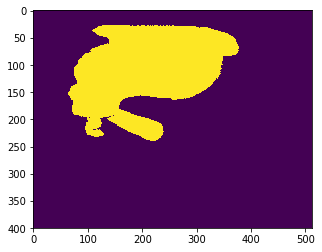

In [11]:
plt.imshow(np.vectorize(lambda x: len(x[0]) > 0)(indexes['bun000']));

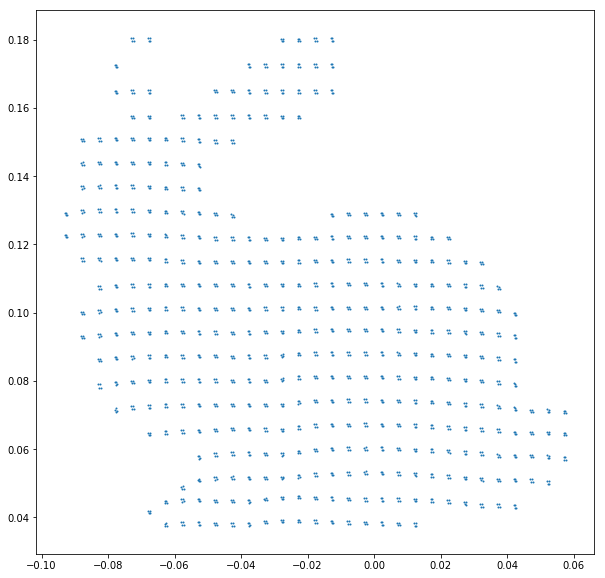

In [12]:
every = 10
plt.figure(figsize=(10, 10))
name = 'bun000'
coords = get_projected_coords(name)
indexes_bool = np.vectorize(lambda x: len(x[0]) > 0)(indexes[name])
x = coords[0, :]
y = coords[1, :]
z = coords[2, :]
xs = []
ys = []
di = [-1, -1, 0, 0]
dj = [-1, 0, -1, 0]
for i in range(1, rows):
    for j in range(1, cols):
        if i % every != 0 or j % every != 0:
            continue
        corner_indexes = []
        for k in range(len(di)):
            i1 = i + di[k]
            j1 = j + dj[k]
            if indexes_bool[i1, j1]:
                corner_indexes.append(indexes[name][i1, j1])
            else:
                break
        if len(corner_indexes) == 4:
            for corner_index in corner_indexes:
                xs.append(x[corner_index])
                ys.append(y[corner_index])
plt.scatter(xs, ys, s=1);

# vis views

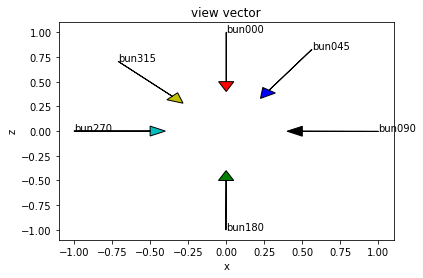

In [13]:
for name in names:
    point = np.array([0, 0, 1], dtype=np.float32)
    rotmtx = quat2rotmtx(configs[name]['quat'])
    point = rotmtx.dot(point[:, np.newaxis])[:, 0]
    plt.scatter([point[0]], [point[2]], c=colors[name], s=0)
    plt.arrow(point[0], point[2], -point[0] / 2, -point[2] / 2, head_width=0.1, head_length=0.1, fc=colors[name])
    plt.text(point[0], point[2], s=name)
plt.title('view vector')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

# w

In [14]:
def dist_simple(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))
    
def dist(coords, p1, p2):
    return dist_simple(coords[:, p1], coords[:, p2])

# def get_local_w(view_vector, ):
def normalize(v):
    v = v / np.sqrt(np.sum(v ** 2))
    return v

def calc_normal(a, b):
    a1, a2, a3 = a
    b1, b2, b3 = b
    normal = np.array([a2*b3 - a3*b2, a3*b1 - a1*b3, a1*b2 - a2*b1], dtype=np.float32)
    return normalize(normal)

In [15]:
def make_w():
    def add_local_w(index, w):
        i, j = index
        result[name][i, j] += w
        counts[name][i, j] += 1
    
    def update_result(triangle):
        a, b, c = triangle
        p_a = coords[:, a[1]]
        p_b = coords[:, b[1]]
        p_c = coords[:, c[1]]
        v_ab = p_b - p_a
        v_ac = p_c - p_a
        normal = calc_normal(v_ab, v_ac)
        local_w = np.sum(normal * view_vector)
        add_local_w(a[0], local_w)
        add_local_w(b[0], local_w)
        add_local_w(c[0], local_w)
        
    def compose_triangle(l):
        return [
            [pairs[i], indexes_4[i]]
            for i in l
        ]
        
    result = dict()
    counts = dict()
    
    for name in names:
        point = np.array([0, 0, 1], dtype=np.float32)
        rotmtx = quat2rotmtx(configs[name]['quat'])
        view_vector = rotmtx.dot(point[:, np.newaxis])[:, 0]
        view_vector = normalize(view_vector)
        
        coords = get_projected_coords(name)
        
        result[name] = np.zeros((rows, cols), dtype=np.float32)
        counts[name] = np.zeros((rows, cols), dtype=np.int32)
        for i in range(1, rows):
            for j in range(1, cols):
                i_diag, j_diag = i - 1, j - 1
                i_n1, j_n1 = i, j_diag
                i_n2, j_n2 = i_diag, j

                pairs = [(i, j), (i_n1, j_n1), (i_diag, j_diag), (i_n2, j_n2)]

                pairs_bool = [len(indexes[name][pair[0], pair[1]][0]) > 0 for pair in pairs]
                true_count = sum(pairs_bool)
                if true_count < 3:
                    continue
                elif true_count == 3:
                    triangle = [
                        ((pair[0], pair[1]), indexes[name][pair[0], pair[1]][0][0])
                        for pair in pairs 
                        if len(indexes[name][pair[0], pair[1]][0]) > 0
                    ]
                    update_result(triangle)
                elif true_count == 4:
                    indexes_4 = [
                        indexes[name][pair[0], pair[1]][0][0]
                        for pair in pairs
                    ]
                    if dist(coords, indexes_4[0], indexes_4[2]) < dist(coords, indexes_4[1], indexes_4[3]):
                        triangle1 = compose_triangle([0, 1, 2])
                        triangle2 = compose_triangle([0, 2, 3])
                    else:
                        triangle1 = compose_triangle([0, 1, 3])
                        triangle2 = compose_triangle([1, 2, 3])
                    update_result(triangle1)
                    update_result(triangle2)
                    
        
        for i in range(rows):
            for j in range(cols):
                if counts[name][i, j] > 0:
                    result[name][i, j] /= counts[name][i, j]
                    
    return result

In [16]:
w = make_w()

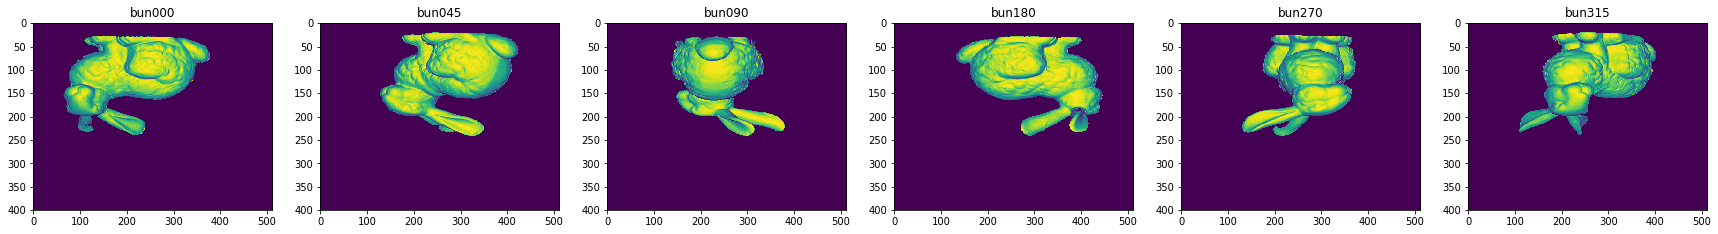

In [17]:
plt.figure(figsize=(len(names) * 5, 5))
for i, name in enumerate(names):
    ax = plt.subplot(1, len(names), i + 1)
    ax.imshow(w[name], vmin=0, vmax=1)
    ax.set_title(name)
plt.show()

# dists between points

In [18]:
dists = []

def add_dist(p1, p2):
    if len(indexes[name][p1[0], p1[1]][0]) > 0 and len(indexes[name][p2[0], p2[1]][0]) > 0:
        index1 = indexes[name][p1[0], p1[1]][0][0]
        index2 = indexes[name][p2[0], p2[1]][0][0]
        dists.append(dist(coords, index1, index2))

for name in names:
    rotmtx = quat2rotmtx(configs[name]['quat'])
    coords = get_projected_coords(name)
    for i in range(rows):
        for j in range(cols):
            if j > 0:
                i_n1, j_n1 = i, j - 1
                add_dist((i, j), (i_n1, j_n1))
            if i > 0:
                i_n2, j_n2 = i - 1, j
                add_dist((i, j), (i_n2, j_n2))

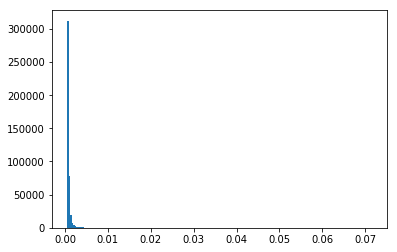

In [19]:
plt.hist(dists, bins=200);

In [20]:
dist_th = 0.003
d_max = 0.01

# set grid

In [21]:
min_x, max_x = float('inf'), -float('inf')
min_y, max_y = float('inf'), -float('inf')
min_z, max_z = float('inf'), -float('inf')

for name in names:
    coords = get_projected_coords(name)
    x = coords[0, :]
    y = coords[1, :]
    z = coords[2, :]
    
    min_x, max_x = min(min_x, np.min(x)), max(max_x, np.max(x))
    min_y, max_y = min(min_y, np.min(y)), max(max_y, np.max(y))
    min_z, max_z = min(min_z, np.min(z)), max(max_z, np.max(z))

print(min_x, max_x)
print(min_y, max_y)
print(min_z, max_z)

-0.09513175 0.06136984
0.033809863 0.18794
-0.06276427 0.059087314


In [22]:
pad = 0.1
p_min_x, p_max_x = min_x - (max_x - min_x) * pad, max_x + (max_x - min_x) * pad
p_min_y, p_max_y = min_y - (max_y - min_y) * pad, max_y + (max_y - min_y) * pad
p_min_z, p_max_z = min_z - (max_z - min_z) * pad, max_z + (max_z - min_z) * pad
print(p_min_x, p_max_x)
print(p_min_y, p_max_y)
print(p_min_z, p_max_z)

-0.1107819065451622 0.07701999917626381
0.018396849930286407 0.20335301458835603
-0.0749494306743145 0.07127247229218484


In [23]:
steps = 40
step = np.min(np.array([max_x - min_x, max_y - min_y, max_z - min_z]) / steps)
step

0.0030462896

In [24]:
step = 0.003
def get_grid(min_, max_, step):
    return np.array([int(min_ / step) * step + i * step for i in range(int(np.ceil((max_ - min_) / step)))])

grid_x = get_grid(p_min_x, p_max_x, step)
grid_y = get_grid(p_min_y, p_max_y, step)
grid_z = get_grid(p_min_z, p_max_z, step)

grids = [
    grid_x,
    grid_y,
    grid_z
]

shape = len(grid_x), len(grid_y), len(grid_z)
shape

(63, 62, 49)

# d

In [25]:
eps = 1e-6

def area(v1, v2):
    return abs(v1[0] * v2[1] - v1[1] * v2[0])

def point_in_triangle(p, a, b, c):
    total_area = area(b - a, c - a)
    area1 = area(a - p, b - p)
    area2 = area(b - p, c - p)
    area3 = area(c - p, a - p)
    return abs(total_area - area1 - area2 - area3) < eps

def form_vec(values, axes):
    result = np.zeros(len(values), dtype=np.float32)
    for i, ax in enumerate(axes):
        result[ax] = values[i]
    return result

def make_d(names, output_dirpath):
    def compose_triangle(l):
        return [
            [pairs[i], indexes_4[i]]
            for i in l
        ]
    
    def update_result(triangle):
        a, b, c = triangle
        if max(dist(coords, a[1], b[1]), dist(coords, a[1], c[1]), dist(coords, b[1], c[1])) > dist_th:
            return
        p_a = coords[:, a[1]]
        p_b = coords[:, b[1]]
        p_c = coords[:, c[1]]
        
        plane_a_b_c = view_vector
        plane_d = -np.sum(plane_a_b_c * p_a)
        
        for i0, coord0 in enumerate(grids[ax0]):
            p_a_p = p_a + view_vector * (coord0 - p_a[ax0]) / view_vector[ax0]
            if dist_simple(p_a_p, p_a) > d_max:
                continue
            p_b_p = p_b + view_vector * (coord0 - p_b[ax0]) / view_vector[ax0]
            p_c_p = p_c + view_vector * (coord0 - p_c[ax0]) / view_vector[ax0]
            
            ax1_coords = [p_a_p[ax1], p_b_p[ax1], p_c_p[ax1]]
            ax2_coords = [p_a_p[ax2], p_b_p[ax2], p_c_p[ax2]]
            
            if not (
                grids[ax1][0] < min(ax1_coords) and max(ax1_coords) < grids[ax1][-1] and \
                grids[ax2][0] < min(ax2_coords) and max(ax2_coords) < grids[ax2][-1]
            ):
                continue
            
            min_ax1 = int(np.ceil((min(ax1_coords) - eps - grids[ax1][0]) / step))
            max_ax1 = int(np.floor((max(ax1_coords) + eps - grids[ax1][0]) / step))
            min_ax2 = int(np.ceil((min(ax2_coords) - eps - grids[ax2][0]) / step))
            max_ax2 = int(np.floor((max(ax2_coords) + eps - grids[ax2][0]) / step))
            
            triangle_2d_a = np.array([p_a_p[ax1], p_a_p[ax2]], dtype=np.float32)
            triangle_2d_b = np.array([p_b_p[ax1], p_b_p[ax2]], dtype=np.float32)
            triangle_2d_c = np.array([p_c_p[ax1], p_c_p[ax2]], dtype=np.float32)
            
#             print([ax0, ax1, ax2], view_vector, coord0, p_a_p, p_b_p, p_c_p)
#             if i0 == len(grids[ax0]) // 2:
#                 fig = plt.figure()
#                 ax = fig.gca()
#                 ax.set_xticks(grids[ax1])
#                 ax.set_yticks(grids[ax2])
#                 plt.scatter(ax1_coords, ax2_coords, c='b', s=1)
#                 plt.grid()
#                 plt.xlabel(ax1)
#                 plt.ylabel(ax2)
#                 plt.show()
#             return True
            
            for i1 in range(min_ax1, max_ax1 + 1):
                coord1 = grids[ax1][i1]
                for i2 in range(min_ax2, max_ax2 + 1):
                    indexes_3d = form_vec([i0, i1, i2], [ax0, ax1, ax2])
                    indexes_3d = indexes_3d.astype(np.int32)
                    if result_w[indexes_3d[0], indexes_3d[1], indexes_3d[2]] > 0:
                        continue
                    coord2 = grids[ax2][i2]
                    grid_point = np.array([coord1, coord2], dtype=np.float32)
                    if point_in_triangle(grid_point, triangle_2d_a, triangle_2d_b, triangle_2d_c):
                        dist_a = dist_simple(triangle_2d_a, grid_point)
                        dist_b = dist_simple(triangle_2d_b, grid_point)
                        dist_c = dist_simple(triangle_2d_c, grid_point)
                        w_dists = np.array([dist_a, dist_b, dist_c], dtype=np.float32)
                        w_dists = 1 / (w_dists + eps)
                        w_dists = w_dists / np.sum(w_dists)
                        ws = np.array([
                            w[name][a[0][0], a[0][1]],
                            w[name][b[0][0], b[0][1]],
                            w[name][c[0][0], c[0][1]]
                        ], dtype=np.float32)
                        w_local = np.sum(ws * w_dists)
                        point_3d = form_vec([coord0, coord1, coord2], [ax0, ax1, ax2])
                        d_local = np.sum(point_3d * plane_a_b_c) + plane_d
                        d_local = -d_local
                        
                        result_w[indexes_3d[0], indexes_3d[1], indexes_3d[2]] = w_local
                        result_d[indexes_3d[0], indexes_3d[1], indexes_3d[2]] = d_local
                        
        
    makedirs(output_dirpath)     
    for name in names:
        point = np.array([0, 0, 1], dtype=np.float32)
        rotmtx = quat2rotmtx(configs[name]['quat'])
        view_vector = rotmtx.dot(point[:, np.newaxis])[:, 0]
        view_vector = normalize(view_vector)
        ax0 = np.argmax(np.abs(view_vector))
        ax1, ax2 = [i for i in range(3) if i != ax0]
        
        coords = get_projected_coords(name)
        
        result_d = np.zeros(shape, dtype=np.float32)
        result_w = np.zeros(shape, dtype=np.float32)
        for i in tqdm(list(range(1, rows))):
            for j in range(1, cols):
                i_diag, j_diag = i - 1, j - 1
                i_n1, j_n1 = i, j_diag
                i_n2, j_n2 = i_diag, j

                pairs = [(i, j), (i_n1, j_n1), (i_diag, j_diag), (i_n2, j_n2)]

                pairs_bool = [len(indexes[name][pair[0], pair[1]][0]) > 0 for pair in pairs]
                true_count = sum(pairs_bool)
                if true_count < 3:
                    continue
                elif true_count == 3:
                    triangle = [
                        ((pair[0], pair[1]), indexes[name][pair[0], pair[1]][0][0])
                        for pair in pairs 
                        if len(indexes[name][pair[0], pair[1]][0]) > 0
                    ]
                    triangles = [triangle]
                elif true_count == 4:
                    indexes_4 = [
                        indexes[name][pair[0], pair[1]][0][0]
                        for pair in pairs
                    ]
                    if dist(coords, indexes_4[0], indexes_4[2]) < dist(coords, indexes_4[1], indexes_4[3]):
                        triangle1 = compose_triangle([0, 1, 2])
                        triangle2 = compose_triangle([0, 2, 3])
                    else:
                        triangle1 = compose_triangle([0, 1, 3])
                        triangle2 = compose_triangle([1, 2, 3])
                    triangles = [triangle1, triangle2]
                for triangle in triangles:
                    if update_result(triangle):
                        return
        filepath = join(output_dirpath, '{}.pickle'.format(name))
        pickle.dump((result_w, result_d), open(filepath, 'wb'))

In [ ]:
make_d(names, '../data/out_0.003')

In [546]:
result_w, result_d = pickle.load(open('../data/out_0.003/bun045.pickle', 'rb'))
result = result_w * result_d

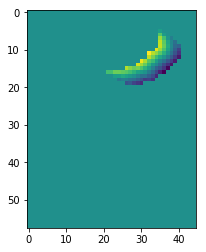

In [547]:
mid_yi = np.argmin(abs(grid_y - mid))
fig = plt.figure()
plt.imshow(result[:, mid_yi, :])
plt.show()

# merge outputs

In [600]:
def get_merged_result(output_dirpath, names_to_merge):
    print(names_to_merge)
    results_d = dict()
    results_w = dict()
    for name in names_to_merge:
        filepath = join(output_dirpath, '{}.pickle'.format(name))
        result_w, result_d = pickle.load(open(filepath, 'rb'))
        results_w[name] = result_w
        results_d[name] = result_d

    shape = result_d.shape
    result = np.zeros(shape, dtype=np.float32)
    for i0 in range(shape[0]):
        for i1 in range(shape[1]):
            for i2 in range(shape[2]):
                ds = np.array([results_d[name][i0, i1, i2] for name in names_to_merge], dtype=np.float32)
                ws = np.array([results_w[name][i0, i1, i2] for name in names_to_merge], dtype=np.float32)
                mask = ws > 0
                if sum(mask) > 0:
                    result[i0, i1, i2] = np.sum(ds[mask] * ws[mask]) / np.sum(ws[mask])
    return result

In [608]:
output_dirpath = '../data/out_0.003'
names_to_merge = names[:2]
result = get_merged_result(output_dirpath, names_to_merge)

['bun000', 'bun045']


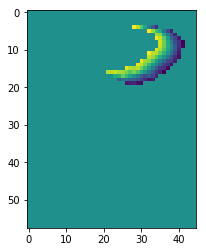

In [609]:
mid_yi = np.argmin(abs(grid_y - mid))
fig = plt.figure()
plt.imshow(result[:, mid_yi, :])
plt.show()

In [630]:
head = """ply
format ascii 1.0
comment created by platoply
element vertex {}
property float32 x
property float32 y
property float32 z
element face {}
property list uint8 int32 vertex_indices
end_header
"""


def result2off(result, output_filepath):
    def add_point(point):
        if point in result_points:
            return result_points[point]
        else:
            l = len(result_points)
            result_points[point] = l
            points_list.append(point)
            return l

    d0 = [-1, 1, 0, 0, 0, 0]
    d1 = [0, 0, -1, 1, 0, 0]
    d2 = [0, 0, 0, 0, -1, 1]
    
    shape = result.shape
    result_points = dict()
    points_list = []
    result_faces = []
    
    for i0 in range(shape[0]):
        for i1 in range(shape[1]):
            for i2 in range(shape[2]):
                for k in range(len(d0)):
                    if result[i0, i1, i2] > eps:
                        j0 = i0 + d0[k]
                        j1 = i1 + d1[k]
                        j2 = i2 + d2[k]
                        ds = [d0[k], d1[k], d2[k]]
                        if 0 <= j0 < shape[0] and 0 <= j1 < shape[1] and 0 <= j2 < shape[2]:
                            ax0 = np.argmax(np.abs(ds))
                            ax1, ax2 = [i for i in range(3) if i != ax0]
                            points = np.zeros([4, 3], dtype=np.int32)
                            points[:, ax0] = (ds[ax0] - 1) / 2
                            points[:, ax1] = np.array([-1, -1, 0, 0], dtype=np.int32)
                            points[:, ax2] = np.array([0, -1, -1, 0], dtype=np.int32)
                            points[:, 0] += i0
                            points[:, 1] += i1
                            points[:, 2] += i2
                            indexes = [add_point(tuple(point)) for point in points]
                            result_faces.append(indexes)
    txt = head.format(len(result_points), len(result_faces))
    for point in points_list:
        txt += '{} {} {}\n'.format(grid_x[point[0]], grid_y[point[1]], grid_z[point[2]])
    for face in result_faces:
        txt += '{} {}\n'.format(len(face), ' '.join(map(str, face)))
    txt = txt.replace('.', ',')
    open(output_filepath, 'w').write(txt)

# save multiple results

In [631]:
names_to_merge_set = [names[:2]]
for names_to_merge in names_to_merge_set:
    output_dirpath = '../data/out_0.003'
    result = get_merged_result(output_dirpath, names_to_merge)
    result2off(result, '../data/out_0.003/{}.ply'.format('_'.join(names_to_merge)))

['bun000', 'bun045']
